In [6]:
import os

os.environ['KERAS_BACKEND'] = 'torch'
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

## Data pre-processing

In [2]:
import h5py

with h5py.File('../data/kinematics/kuka_expert_causal_12k_n10_v2_f10.h5', 'r') as hf:
    kuka_fwd = hf['kuka_kinematics_fwd'][()]
    kuka_inv = hf['kuka_kinematics_inv'][()]

In [3]:
import h5py

with h5py.File('../data/kinematics/kuka_expert_traj_12k_n10_v2_f10_edge-pad.h5', 'r') as hf:
    endpoints = hf['kuka_kinematics_endpoints'][()]
    trajS = hf['kuka_kinematics_trajS'][()]
    trajA = hf['kuka_kinematics_trajA'][()]

In [20]:
import numpy as np

X_fwd, y_fwd = np.hsplit(kuka_fwd, [17])

(
    X_fwd_joints, X_fwd_eff_xyz,
    X_fwd_action
) = np.hsplit(X_fwd, [7, 10])

y_fwd_joints, y_fwd_eff_xyz = np.hsplit(y_fwd, [7])

X_inv, y_inv = np.hsplit(kuka_inv, [20])

(
    X_inv_joints_0, X_inv_eff_xyz_0,
    X_inv_joints_1, X_inv_eff_xyz_1
) = np.hsplit(
    X_inv,
    [
        7, 10,  # S0
        17      # S1
    ]
)
X_inv_mod = np.hstack((X_inv_joints_0, X_inv_eff_xyz_0, X_inv_eff_xyz_1))

## Forward model

In [12]:
from keras.api.layers import Input, Dense
from keras.api.models import Model

inp = Input(shape=(X_fwd.shape[1],))
h = Dense(30, activation='tanh')(inp)

h_joints = Dense(20, activation='tanh')(h)
joints_out = Dense(7, activation='linear', name='joints_out')(h_joints)

h_eff_xyz = Dense(20, activation='tanh')(h)
eff_xyz_out = Dense(3, activation='linear', name='eff_xyz_out')(h_eff_xyz)

fwd_model = Model(
    inputs=inp,
    outputs=[joints_out, eff_xyz_out],
    name='fwd_model'
)

fwd_model.summary()

Model: "fwd_model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 17)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 30)        │        540 │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 20)        │        620 │ dense_6[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 20)        │        620 │ dense_6[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ joints_out (Dense)  │ (None, 7)         │        147 │ dense_7[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ eff_xyz_out (Dense) │ (None, 3)         │         63 │ dense_8[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,990 (7.77 KB)

 Trainable params: 1,990 (7.77 KB)

 Non-trainable params: 0 (0.00 B)

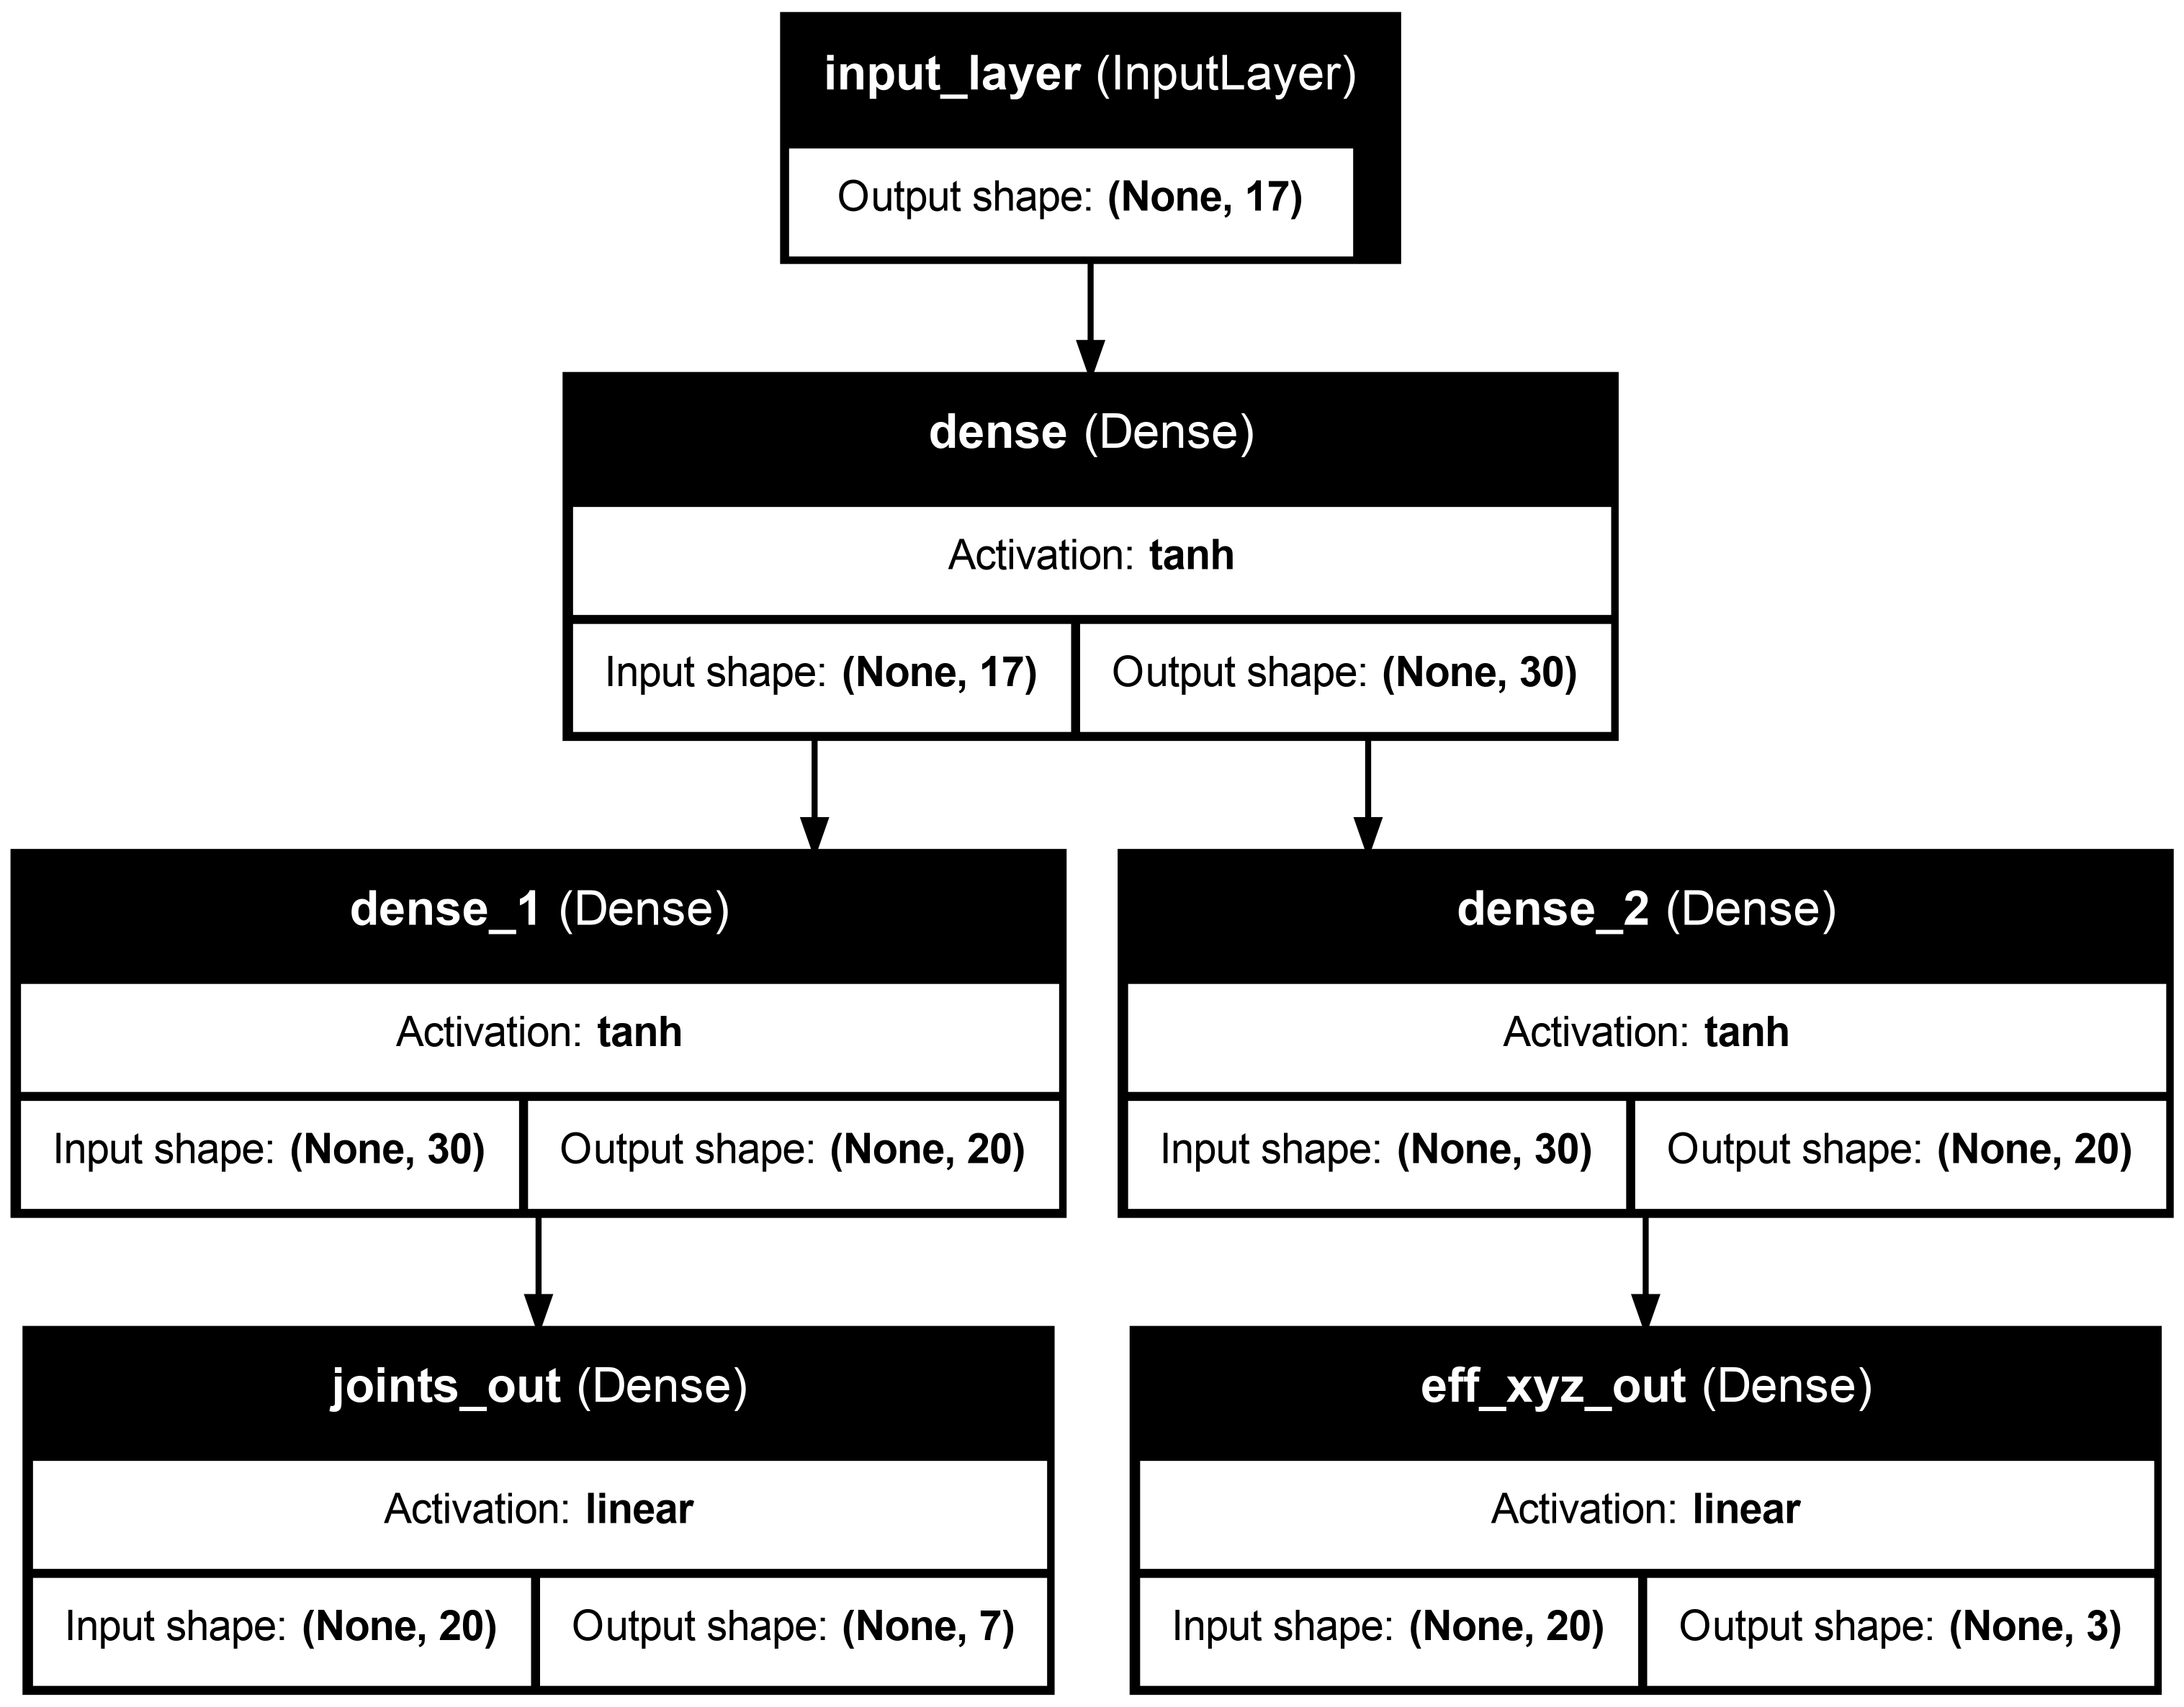

In [7]:
# from IPython.display import Image
from keras.api.utils import plot_model

plot_model(
    fwd_model,
    to_file='../plots/kinematics/kuka_fwd_model.png',
    show_shapes=True,
    show_layer_names=True,
    show_layer_activations=True,
    dpi=300
)
# Image('plots/kuka/kuka_fwd_model.png')

In [13]:
from keras.api.optimizers import Adam
from keras.api.losses import MeanSquaredError, MeanAbsoluteError
from keras.api.callbacks import TensorBoard

fwd_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss={
        'joints_out': MeanSquaredError(),
        'eff_xyz_out': MeanSquaredError()
    },
    metrics={
        'joints_out': [MeanAbsoluteError()],
        'eff_xyz_out': [MeanAbsoluteError()]
    }
)

fwd_history = fwd_model.fit(
    x=X_fwd,
    y={
        'joints_out': y_fwd_joints,
        'eff_xyz_out': y_fwd_eff_xyz
    },
    batch_size=256,
    epochs=60,
    callbacks=[TensorBoard(log_dir='../logs/kinematics/fwd_60ep_torch', write_graph=False)],
    validation_split=0.2,
    shuffle=True,
    verbose=False
)

fwd_model.save('../models/kinematics/kuka_fwd_60ep.keras')

## Inverse model

In [24]:
from keras.api.layers import Input, Dense
from keras.api.models import Model

inp = Input(shape=(X_inv_mod.shape[1],))
h = Dense(40, activation='tanh')(inp)
h = Dense(60, activation='tanh')(h)
h = Dense(60, activation='tanh')(h)
h = Dense(40, activation='tanh')(h)

joints_out = Dense(7, activation='linear', name='joints_out')(h)

inv_model = Model(
    inputs=inp,
    outputs=[joints_out],
    name='inv_model'
)

inv_model.summary()

Model: "inv_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 13)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 40)             │           560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 60)             │         2,460 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 60)             │         3,660 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 40)             │         2,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ joints_out (Dense)              │ (None, 7)              │           287 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,407 (36.75 KB)

 Trainable params: 9,407 (36.75 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from keras.api.utils import plot_model

plot_model(
    inv_model,
    to_file=f'../plots/kinematics/kuka_inv_model_sep.png',
    show_shapes=True,
    show_layer_names=True,
    show_layer_activations=True,
    expand_nested=True,
    dpi=300
)

In [25]:
from keras.api.optimizers import Adam, AdamW
from keras.api.losses import MeanSquaredError, MeanAbsoluteError
from keras.api.callbacks import TensorBoard

inv_model.compile(
    optimizer=AdamW(learning_rate=0.001, weight_decay=0.004),
    loss=MeanSquaredError(),
    metrics=[MeanAbsoluteError()]
)

inv_history = inv_model.fit(
    x=X_inv_mod,
    y=y_inv,
    batch_size=256,
    epochs=100,
    callbacks=[TensorBoard(log_dir='../logs/kinematics/inv_100ep_torch', write_graph=False)],
    validation_split=0.2,
    shuffle=True,
    verbose=False
)

inv_model.save('../models/kinematics/kuka_inv_sep_100ep.keras')

## Trajectory model

In [26]:
import numpy as np

train_size = 0.8
test_size = 1 - train_size
test_idx = int(trajS.shape[0] * train_size)

endpoints_train, endpoints_test = np.vsplit(endpoints, [test_idx])
trajS_train, trajS_test = np.vsplit(trajS, [test_idx])
trajA_train, trajA_test = np.vsplit(trajA, [test_idx])

In [27]:
y_traj_joints, y_traj_eff_xyz = np.split(trajS_train, [7], axis=2)

In [28]:
X_traj = endpoints_train

In [32]:
from keras.api.models import Model
from keras.api.layers import Input, LSTM, GRU, RepeatVector, TimeDistributed, Dense

n_timesteps = trajS.shape[1]
# h_dim = trajS.shape[2]

inp = Input(shape=(X_traj.shape[1],))
h = RepeatVector(n_timesteps)(inp)
# h = LSTM(100, return_sequences=True)(h)
h = GRU(100, return_sequences=True)(h)
h = TimeDistributed(Dense(100, activation='tanh'))(h)

h_joints = TimeDistributed(Dense(20, activation='tanh'))(h)
joints_out = TimeDistributed(Dense(7, activation='linear'), name='joints_out')(h_joints)

h_eff_xyz = TimeDistributed(Dense(20, activation='tanh'))(h)
eff_xyz_out = TimeDistributed(Dense(3, activation='linear'), name='eff_xyz_out')(h_eff_xyz)

traj_model = Model(
    inputs=inp,
    outputs=[joints_out, eff_xyz_out],
    name='traj_model'
)

traj_model.summary()

Model: "traj_model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8       │ (None, 20)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_1     │ (None, 40, 20)    │          0 │ input_layer_8[0]… │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_1 (GRU)         │ (None, 40, 100)   │     36,600 │ repeat_vector_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_3  │ (None, 40, 100)   │     10,100 │ gru_1[0][0]       │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_4  │ (None, 40, 20)    │      2,020 │ time_distributed… │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_5  │ (None, 40, 20)    │      2,020 │ time_distributed… │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ joints_out          │ (None, 40, 7)     │        147 │ time_distributed… │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ eff_xyz_out         │ (None, 40, 3)     │         63 │ time_distributed… │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 50,950 (199.02 KB)

 Trainable params: 50,950 (199.02 KB)

 Non-trainable params: 0 (0.00 B)

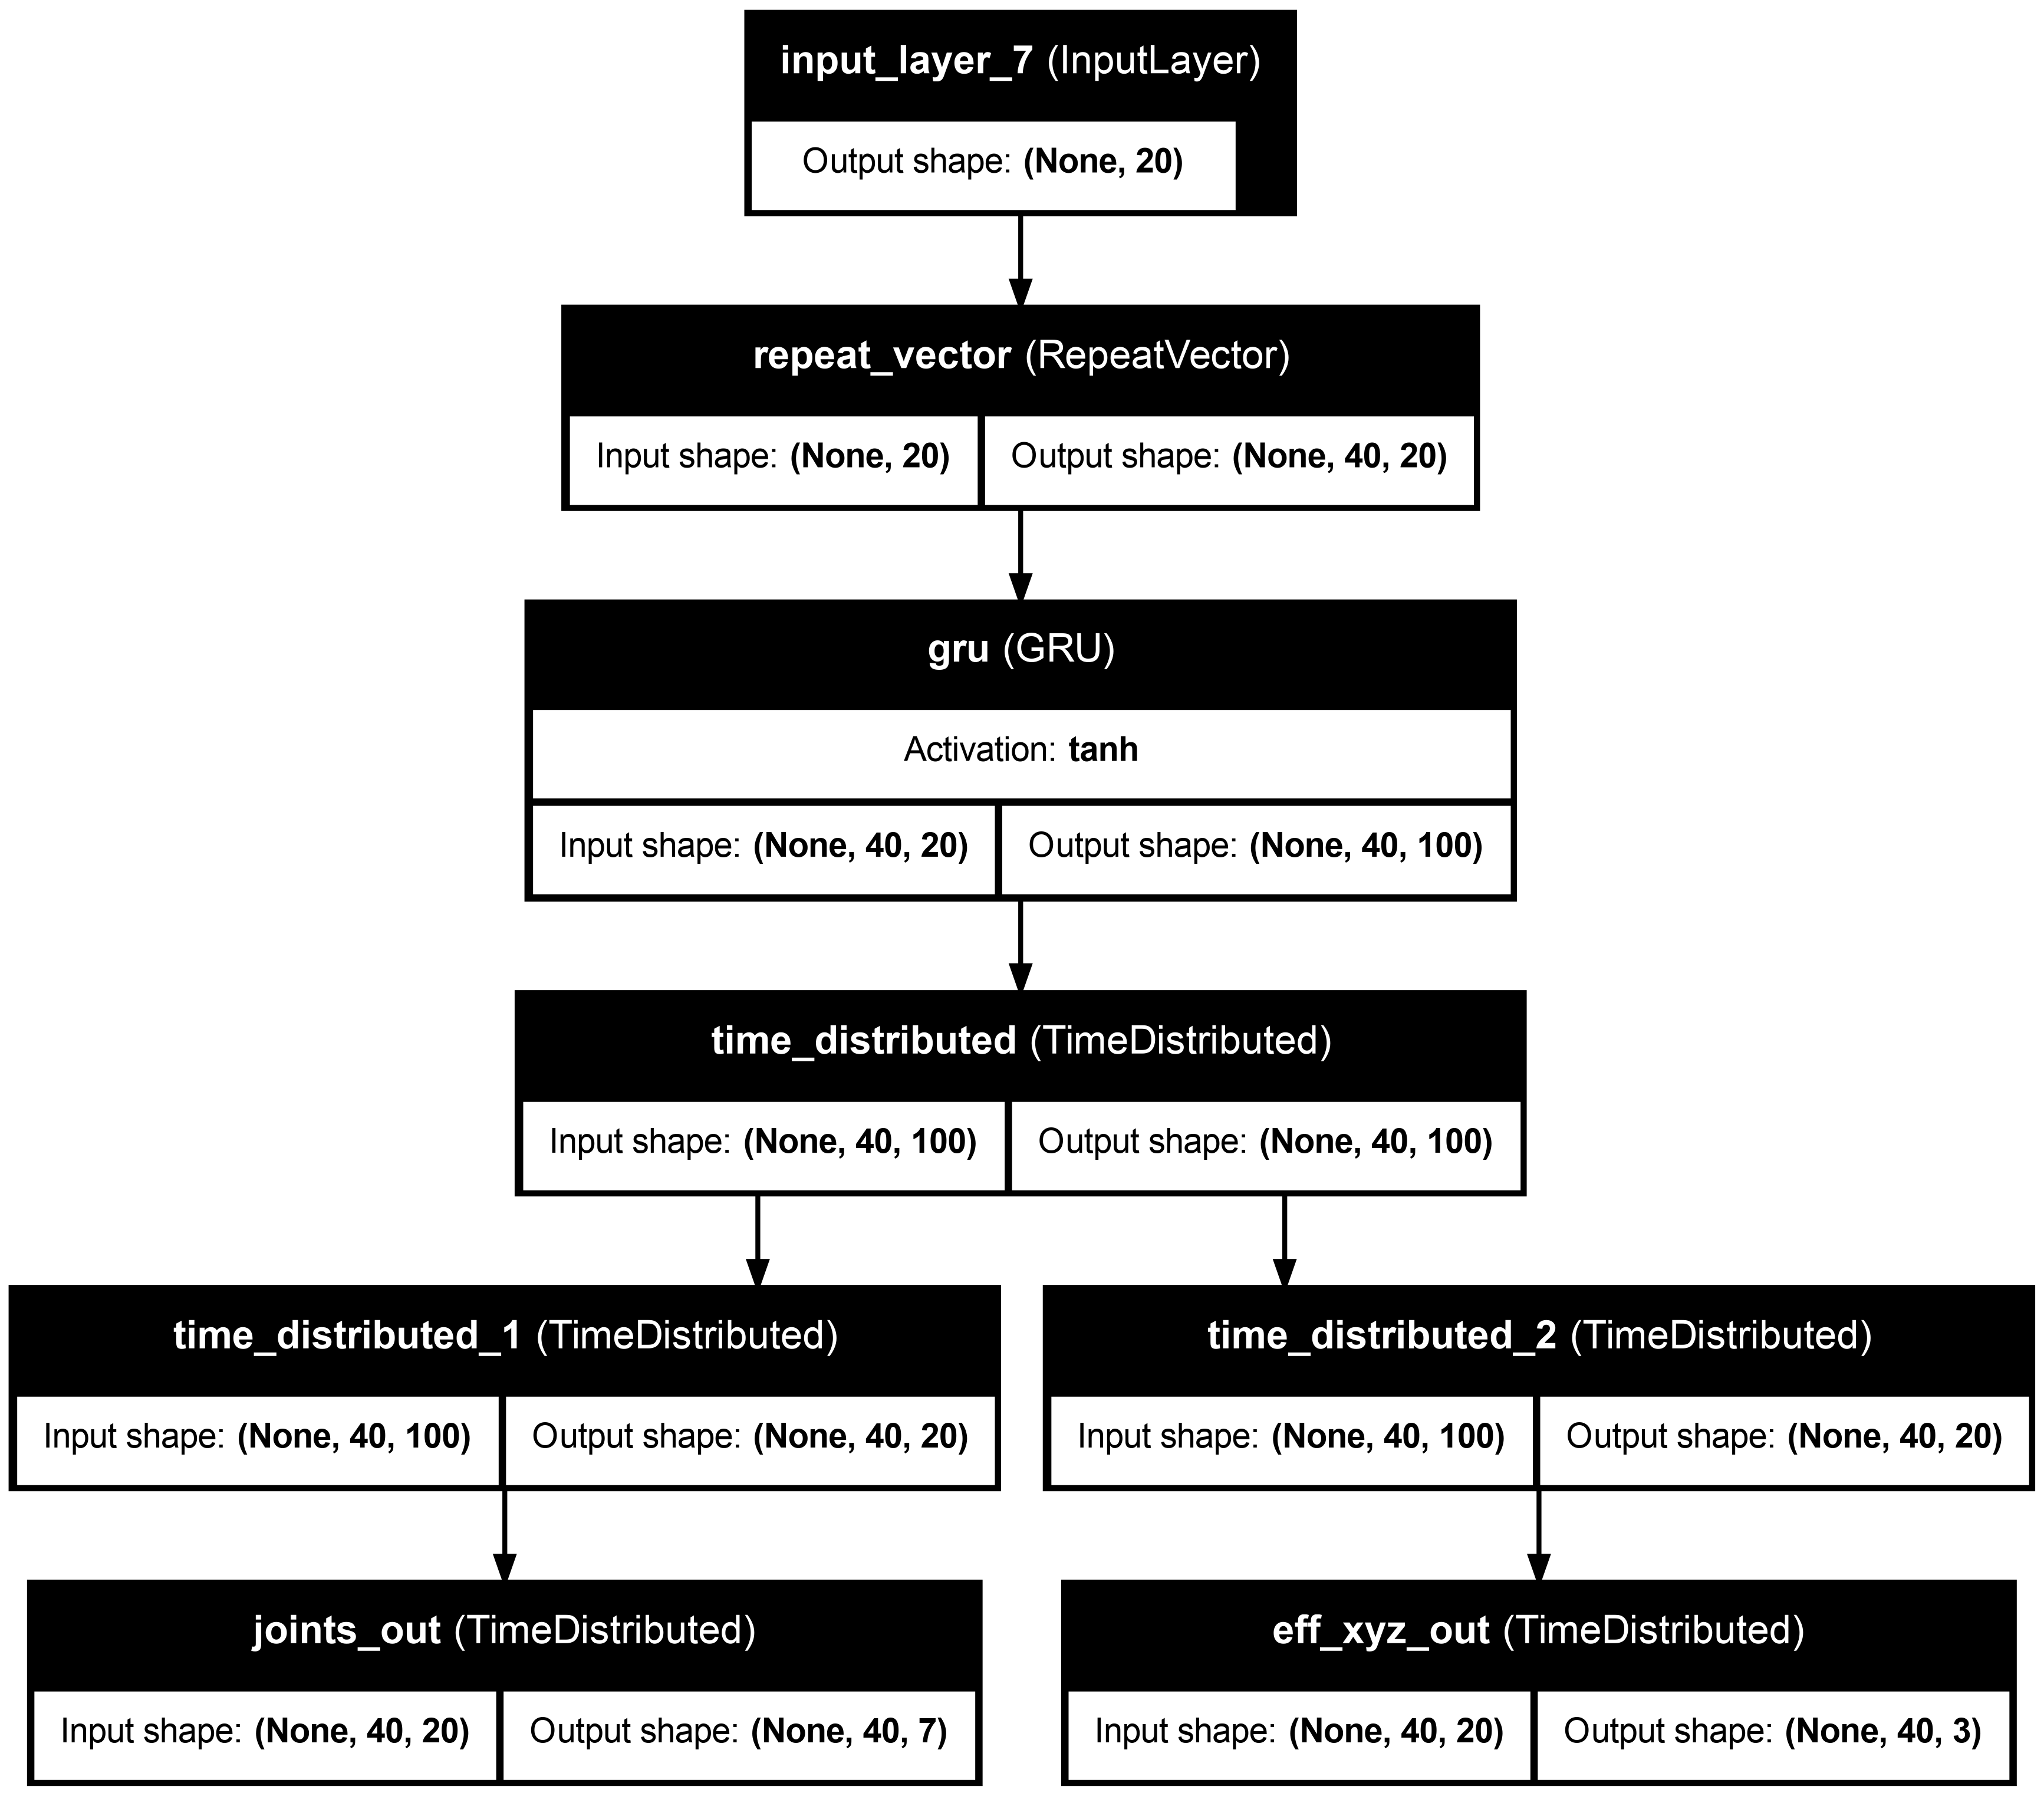

In [30]:
from keras.api.utils import plot_model

plot_model(
    traj_model,
    to_file=f'../plots/kinematics/kuka_gru1-100_traj_model.png',
    show_shapes=True,
    show_layer_names=True,
    show_layer_activations=True,
    expand_nested=True,
    dpi=300
)

In [33]:
from keras.api.optimizers import Adam
from keras.api.losses import MeanSquaredError, MeanAbsoluteError
from keras.api.callbacks import TensorBoard

traj_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss={
        'joints_out': MeanSquaredError(),
        'eff_xyz_out': MeanSquaredError()
    },
    metrics={
        'joints_out': [MeanAbsoluteError()],
        'eff_xyz_out': [MeanAbsoluteError()]
    }
)

traj_history = traj_model.fit(
    x=X_traj,
    y={
        'joints_out': y_traj_joints,
        'eff_xyz_out': y_traj_eff_xyz
    },
    batch_size=256,
    epochs=1000,
    callbacks=[TensorBoard(log_dir='../logs/kinematics/traj_gru1-100_1000ep_torch', write_graph=False)],
    validation_split=0.2,
    shuffle=True,
    verbose=False
)

traj_model.save('../models/kinematics/kuka_traj_gru1-100_1000ep.keras')